In [1]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from adjustText import adjust_text
from pandas import json_normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

2024-06-22 05:30:59.467779: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-22 05:30:59.490644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 05:30:59.490670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 05:30:59.491280: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-22 05:30:59.495513: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# UMAPのverを確認
print(umap.__version__)

0.5.5


In [3]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.family"] = "IPAexGothic"

In [4]:
class CFG:
    input_dir = "../input"
    output_dir = "../output"
    random_seed = 42
    exp_no = "test_analysis"

In [5]:
train_df = pd.read_csv(f"{CFG.input_dir}/chapter2_demo_data_postprocess.csv")
train_df

,サンプルID,サンプル作成日,担当者,備考,材料１,材料２,材料３,材料４,材料５,材料６,...,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性(n10,画像濃度,粘度,表面張力,保存後粘度,保存後状態
0,DP_001,45310,高岡,NaN,46.9,40,0,2,0,2.0,...,25,NaN,10,5,2.4,1.06,9.0,35,NaN,NaN
1,DP_002,45310,高岡,NaN,47.4,40,0,2,0,1.5,...,25,NaN,10,5,2.4,1.07,9.0,38,NaN,NaN
2,DP_003,45310,高岡,NaN,47.7,40,0,2,0,1.2,...,25,NaN,10,5,2.4,1.07,9.0,40,NaN,NaN
3,DP_004,45310,高岡,NaN,47.9,40,0,2,0,1.0,...,25,NaN,10,5,2.4,1.08,9.0,41,NaN,NaN
4,DP_005,45310,高岡,NaN,48.4,40,0,2,0,0.5,...,25,NaN,10,5,2.4,1.09,9.0,44,NaN,NaN
5,DP_006,45321,福原,ref,47.4,40,0,2,0,1.5,...,25,NaN,10,5,2.7,1.07,9.1,38,NaN,NaN
6,DP_007,45321,福原,NaN,47.4,40,0,2,0,0.0,...,25,NaN,10,5,2.7,1.05,9.1,37,NaN,NaN
7,DP_008,45321,福原,NaN,47.4,40,0,2,0,0.0,...,25,NaN,10,5,2.7,1.02,9.1,39,NaN,NaN
8,DP_009,45321,福原,NaN,45.4,40,0,2,0,1.5,...,25,NaN,10,5,3.1,1.07,10.3,36,NaN,NaN
9,DP_010,45321,福原,NaN,43.4,40,0,2,0,1.5,...,25,NaN,10,5,3.6,1.07,11.5,34,NaN,NaN


In [6]:
test_df = pd.read_csv(f"{CFG.input_dir}/chapter2_demo_data_postprocess_test.csv")
test_df

,サンプルID,サンプル作成日,担当者,備考,材料１,材料２,材料３,材料４,材料５,材料６,...,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性(n10,画像濃度,粘度,表面張力,保存後粘度,保存後状態
0,DP_test_01,NaN,NaN,NaN,38.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.64,10.3,32,76.7,ゲル化
1,DP_test_02,NaN,NaN,NaN,38.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.61,10.2,32,12.6,正常
2,DP_test_03,NaN,NaN,NaN,38.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.57,10.0,32,33.7,ゲル化
3,DP_test_04,NaN,NaN,NaN,40.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.46,9.2,34,11.6,正常
4,DP_test_05,NaN,NaN,NaN,40.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.43,9.1,34,11.5,正常
5,DP_test_06,NaN,NaN,NaN,40.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.41,9.0,34,11.4,正常
6,DP_test_07,NaN,NaN,NaN,42.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.25,8.1,35,10.5,正常
7,DP_test_08,NaN,NaN,NaN,42.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.24,8.1,35,10.5,正常
8,DP_test_09,NaN,NaN,NaN,42.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.22,8.0,35,10.4,正常


In [7]:
numeric_parameter_cols = [
    # 'サンプルID', 'サンプル名', 'サンプル作成日', '担当者', '備考',
    "材料１",
    "材料２",
    "材料３",
    "材料４",
    "材料５",
    "材料６",
    "材料７",
    "材料８",
    "材料９",
    "材料１０",
    "材料１１",
    "材料１２",
    "材料１３",
    # "塗布量",
    # "乾燥方式",
    # "乾燥温度",
    # '乾燥時間',
    # "擦過回数",
    # "擦過圧力",
    # '耐擦過性(n10','画像濃度', '粘度', '表面張力', '保存後粘度'
]

In [8]:
scaler_x = StandardScaler()
scaler_x.fit(train_df[numeric_parameter_cols])
scaler_x

StandardScaler()

In [9]:
X_train = scaler_x.transform(train_df[numeric_parameter_cols])
X_train

array([[ 1.00830673,  0.75592895, -0.75438695,  0.55339859, -0.68624357,
         1.53976945, -0.1767767 , -0.1767767 ,  0.12768848, -0.35355339,
        -0.86677605, -0.2943724 ,  0.        ],
       [ 1.16797142,  0.75592895, -0.75438695,  0.55339859, -0.68624357,
         0.31831772, -0.1767767 , -0.1767767 ,  0.12768848, -0.35355339,
        -0.86677605, -0.2943724 ,  0.        ],
       [ 1.26377024,  0.75592895, -0.75438695,  0.55339859, -0.68624357,
        -0.41455331, -0.1767767 , -0.1767767 ,  0.12768848, -0.35355339,
        -0.86677605, -0.2943724 ,  0.        ],
       [ 1.32763612,  0.75592895, -0.75438695,  0.55339859, -0.68624357,
        -0.903134  , -0.1767767 , -0.1767767 ,  0.12768848, -0.35355339,
        -0.86677605, -0.2943724 ,  0.        ],
       [ 1.48730081,  0.75592895, -0.75438695,  0.55339859, -0.68624357,
        -2.12458573, -0.1767767 , -0.1767767 ,  0.12768848, -0.35355339,
        -0.86677605, -0.2943724 ,  0.        ],
       [ 1.16797142,  0.755928

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


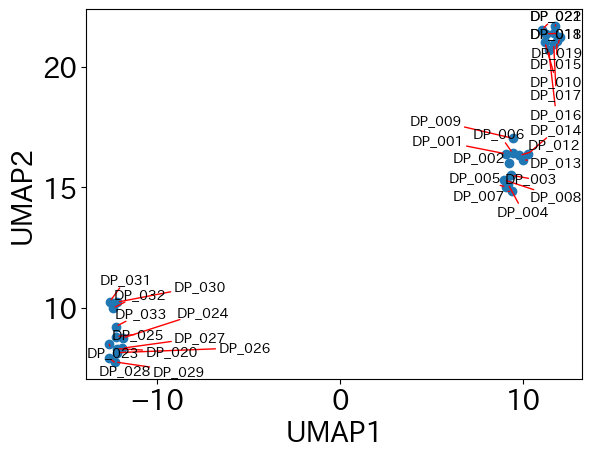

In [21]:
# UMAPを実行、n_components=2、random_state=CFG.random_seed
umap_ = umap.UMAP(
    n_components=2, random_state=CFG.random_seed, n_neighbors=5,
)  # n_neighborsのデフォルト値は15
X_train_umap = umap_.fit_transform(X_train)
X_train_umap

# X_train_umapをDataFrameに変換
train_umap_df = pd.DataFrame(X_train_umap, columns=["UMAP1", "UMAP2"])

# train_umap_dfの散布図を描画
plt.scatter(train_umap_df["UMAP1"], train_umap_df["UMAP2"])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
# plt.txtで対応するサンプルIDを表示、adjustTextモジュールを使用して、重なりがないように表示
texts = [
    plt.text(
        train_umap_df["UMAP1"][i],
        train_umap_df["UMAP2"][i],
        train_df["サンプルID"][i],
        fontsize=10,
    )
    for i in range(len(train_umap_df))
]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="red"))
plt.show()

In [11]:
X_test = scaler_x.transform(test_df[numeric_parameter_cols])
X_test

array([[-1.70599306, -1.32287566,  1.32017716, -1.18585412,  0.99124071,
         0.31831772, -0.1767767 , -0.1767767 , -1.55779945,  3.04055916,
         0.63867709, -0.2943724 ,  0.        ],
       [-1.70599306, -1.32287566,  1.32017716, -1.18585412,  0.99124071,
         0.31831772, -0.1767767 , -0.1767767 ,  0.12768848,  1.76776695,
         0.63867709, -0.2943724 ,  0.        ],
       [-1.70599306, -1.32287566,  1.32017716, -1.18585412,  0.99124071,
         0.31831772, -0.1767767 , -0.1767767 ,  1.81317641,  0.49497475,
         0.63867709, -0.2943724 ,  0.        ],
       [-1.06733428, -1.32287566,  1.32017716, -1.18585412,  0.99124071,
         0.31831772, -0.1767767 , -0.1767767 , -1.55779945,  2.19203102,
         0.63867709, -0.2943724 ,  0.        ],
       [-1.06733428, -1.32287566,  1.32017716, -1.18585412,  0.99124071,
         0.31831772, -0.1767767 , -0.1767767 , -0.43414083,  1.34350288,
         0.63867709, -0.2943724 ,  0.        ],
       [-1.06733428, -1.322875

In [12]:
umap_ = umap.UMAP(
    n_components=2, random_state=CFG.random_seed, n_neighbors=5
)  # n_neighborsのデフォルト値は15

result_umap = umap_.fit(X_train)
result_umap

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_neighbors=5, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [13]:
X_train_umap = result_umap.transform(X_train)
X_train_umap

array([[  9.083426 ,  16.38562  ],
       [  9.272798 ,  15.994107 ],
       [  9.386294 ,  15.4990015],
       [  9.183087 ,  15.149899 ],
       [  9.108389 ,  15.005613 ],
       [  9.455264 ,  16.406939 ],
       [  9.425613 ,  14.849307 ],
       [  8.961606 ,  15.309935 ],
       [  9.456777 ,  17.030952 ],
       [ 11.211023 ,  21.004206 ],
       [ 11.267955 ,  21.362553 ],
       [  9.81526  ,  16.317295 ],
       [ 10.008639 ,  16.139214 ],
       [ 10.300749 ,  16.392107 ],
       [ 11.8833685,  21.041136 ],
       [ 11.41837  ,  20.699657 ],
       [ 11.694881 ,  20.943264 ],
       [ 11.706417 ,  21.371752 ],
       [ 12.032811 ,  21.207449 ],
       [-12.217553 ,   8.320177 ],
       [ 11.045986 ,  21.521736 ],
       [ 11.79321  ,  21.681992 ],
       [-12.61366  ,   8.499292 ],
       [-11.88253  ,   8.759585 ],
       [-12.233719 ,   8.820272 ],
       [-12.206641 ,   8.154195 ],
       [-11.918968 ,   8.3371935],
       [-12.632435 ,   7.9396057],
       [-12.302683 ,

In [14]:
X_test_umap = result_umap.transform(X_test)
X_test_umap

array([[-13.0266   ,   9.879158 ],
       [-13.1734705,   8.904849 ],
       [-13.169518 ,   8.393283 ],
       [-12.569093 ,  10.693694 ],
       [-11.670097 ,   9.487646 ],
       [-13.184992 ,   8.575972 ],
       [-13.004412 ,   9.62717  ],
       [-11.564745 ,   9.426176 ],
       [-13.126486 ,   8.966959 ]], dtype=float32)

In [15]:
train_umap_df = pd.DataFrame(X_train_umap, columns=["UMAP1", "UMAP2"])
test_umap_df = pd.DataFrame(X_test_umap, columns=["UMAP1", "UMAP2"])

In [16]:
train_umap_df

,UMAP1,UMAP2
0,9.083426,16.385620
1,9.272798,15.994107
2,9.386294,15.499002
3,9.183087,15.149899
4,9.108389,15.005613
5,9.455264,16.406939
6,9.425613,14.849307
7,8.961606,15.309935
8,9.456777,17.030952
9,11.211023,21.004206


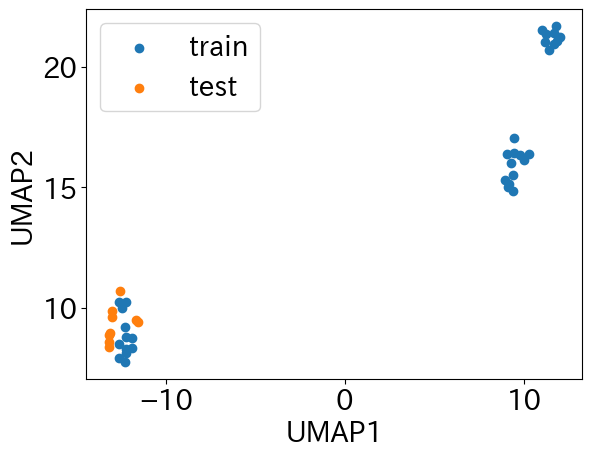

In [17]:
plt.scatter(train_umap_df["UMAP1"], train_umap_df["UMAP2"])
plt.scatter(test_umap_df["UMAP1"], test_umap_df["UMAP2"])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(["train", "test"])
plt.show()

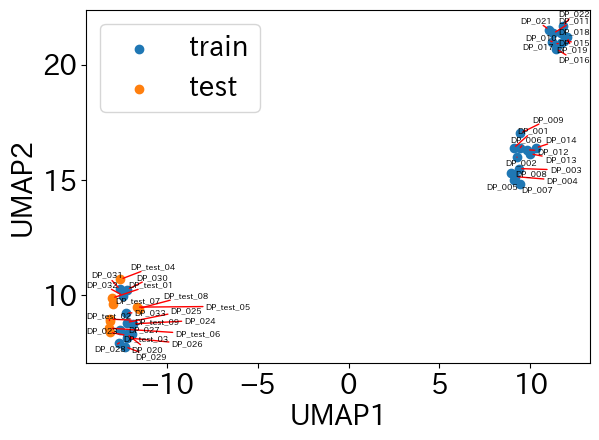

In [19]:
fig, ax = plt.subplots()
ax.scatter(train_umap_df["UMAP1"], train_umap_df["UMAP2"], label='train')
ax.scatter(test_umap_df["UMAP1"], test_umap_df["UMAP2"], label='test')

# テキストのサイズを小さく設定
texts = [
    ax.text(x, y, s, fontsize=6)
    for x, y, s in zip(
        train_umap_df["UMAP1"].values,
        train_umap_df["UMAP2"].values,
        train_df["サンプルID"].values,
    )
]
texts += [
    ax.text(x, y, s, fontsize=6)
    for x, y, s in zip(
        test_umap_df["UMAP1"].values,
        test_umap_df["UMAP2"].values,
        test_df["サンプルID"].values,
    )
]

# adjust_textを使用してテキストが重ならないように調整
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="red"))

# 軸ラベルと凡例の設定
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.tight_layout()
plt.show()
